## 房价预测import和下载数据集

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import folium
from folium import plugins

std_scaler = StandardScaler()
%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('paper')

UsageError: Line magic function `%%matplotlib` not found.


## 数据

In [2]:
path_datasets = r'./datasets'
files = os.listdir(path_datasets)
files

['calendar.csv',
 'gz',
 'listings.csv',
 'listings_1.csv',
 'neighbourhoods.csv',
 'neighbourhoods.geojson',
 'reviews.csv',
 'reviews_1.csv']

读取文件

In [3]:
csv_files = glob.glob(path_datasets + r'\*.csv')
name = [os.path.basename(f).strip('.csv') for f in csv_files]
file_list = {n: pd.read_csv(fi) for n, fi in zip(name, csv_files)}

观察文件形式

In [4]:
listing: pd.DataFrame = file_list['listing']

分析房间类型

In [5]:
room_type: pd.Series = listing.room_type
types = room_type.unique()
print(f'has {room_type.nunique()} type rooms: {room_type.unique()}')
plot_dict: pd.Series = room_type.value_counts()
# plot_dict = {}
# for tp in types:
#     plot_dict[tp] = sum((room_type == tp))

has 4 type rooms: ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']


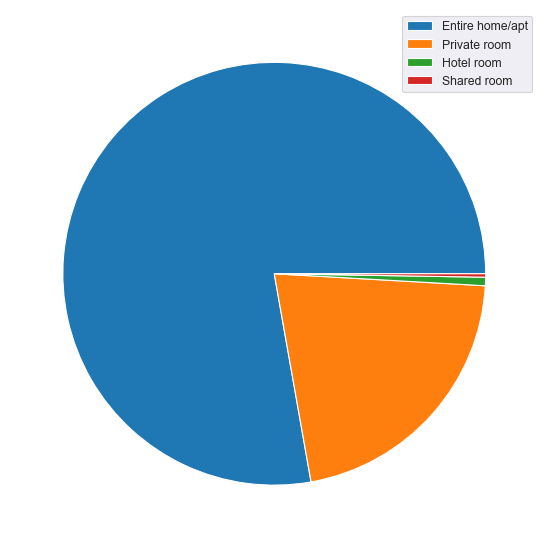

In [6]:
plt.figure(figsize=(7, 7), dpi=100)
plt.pie(plot_dict.values)
plt.legend(plot_dict.keys())
plt.show()
# plt.dis(plot_dict.values())

分析地理位置与房价的关系

In [7]:
#pos
pos = listing[['latitude', 'longitude']]
mean_pos = pos.mean().to_numpy()
m = folium.Map(mean_pos, zoom_start=11.4)
price = listing.price.to_numpy()

In [8]:
data_price = pd.concat([pos, listing.price], 1)
plugins.HeatMap(data_price, radius=12).add_to(m)
m

分析社区环境

has 22 types of neigborhood(s):
 ['Oostelijk Havengebied - Indische Buurt' 'Centrum-Oost' 'Centrum-West'
 'Zuid' 'De Baarsjes - Oud-West' 'Bos en Lommer' 'De Pijp - Rivierenbuurt'
 'Oud-Oost' 'Noord-West' 'Westerpark' 'Slotervaart' 'Oud-Noord'
 'Watergraafsmeer' 'IJburg - Zeeburgereiland' 'Noord-Oost'
 'Buitenveldert - Zuidas' 'Geuzenveld - Slotermeer'
 'De Aker - Nieuw Sloten' 'Osdorp' 'Bijlmer-Centrum'
 'Gaasperdam - Driemond' 'Bijlmer-Oost']
--------------------


<BarContainer object of 22 artists>

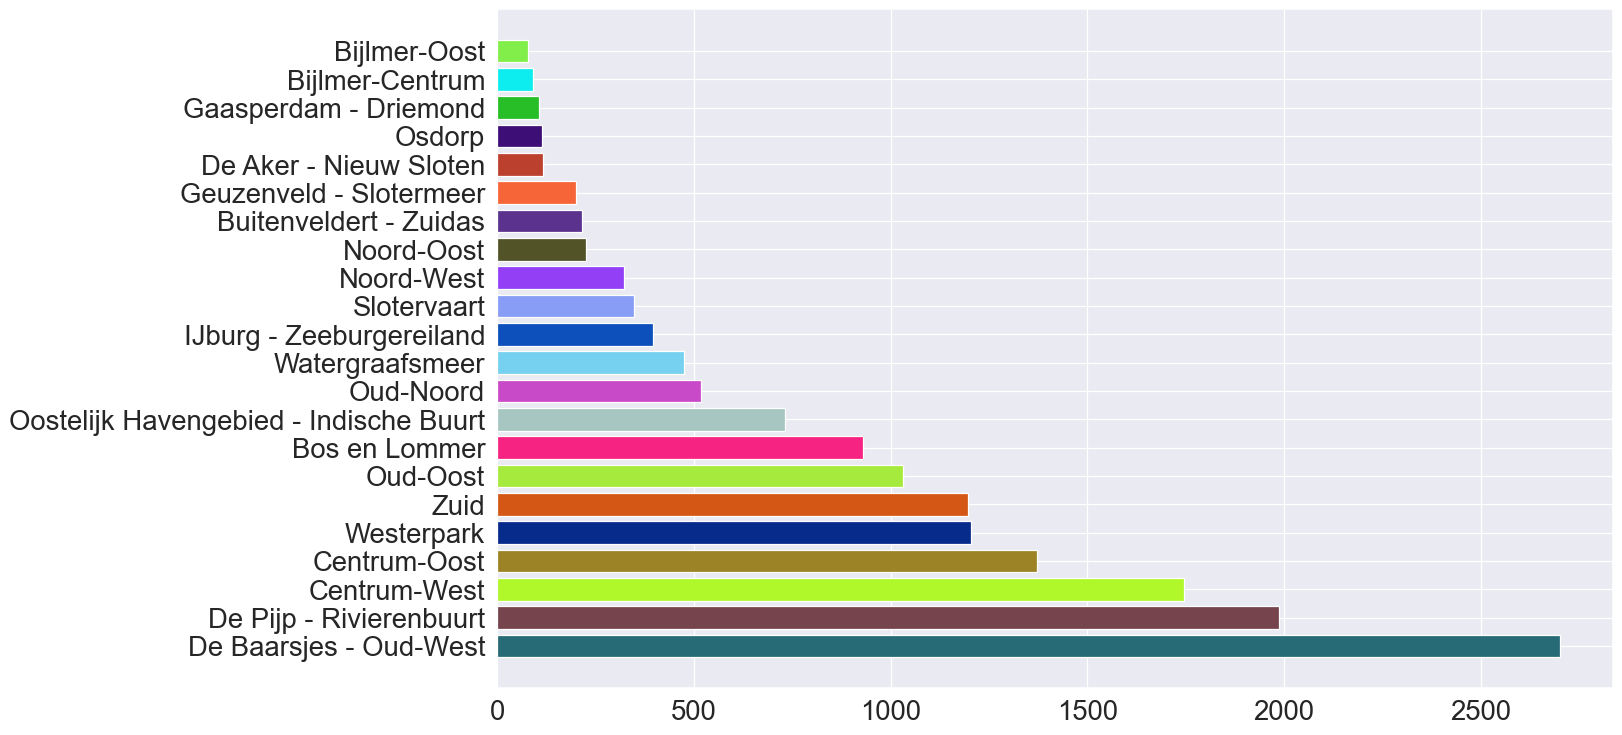

In [27]:
neigb_types = listing['neighbourhood'].unique()
neigb = listing['neighbourhood']
print(f'has {len(neigb_types)} types of neigborhood(s):\n {neigb_types}')
print('-' * 20)

counts = listing['neighbourhood'].value_counts()
# plt.hist(counts.values, label=counts.index)
c = np.random.rand(len(counts), 3)
sns.set_theme(font_scale=2)
plt.figure(figsize=(16, 10), dpi=90)
plt.barh(range(len(counts)), counts.values, tick_label=counts.index, color=c)

## 预测房价

数据预处理

In [34]:
pd.options.mode.chained_assignment = None
values = listing.drop(['neighbourhood_group', 'license', 'id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
values.dropna(inplace=True, axis=0)
disper_columns = ['neighbourhood', 'room_type']
conti_values = values.drop(disper_columns, axis=1)
y = values['price'].to_numpy()[:, np.newaxis]

计算协方差矩阵

<AxesSubplot:>

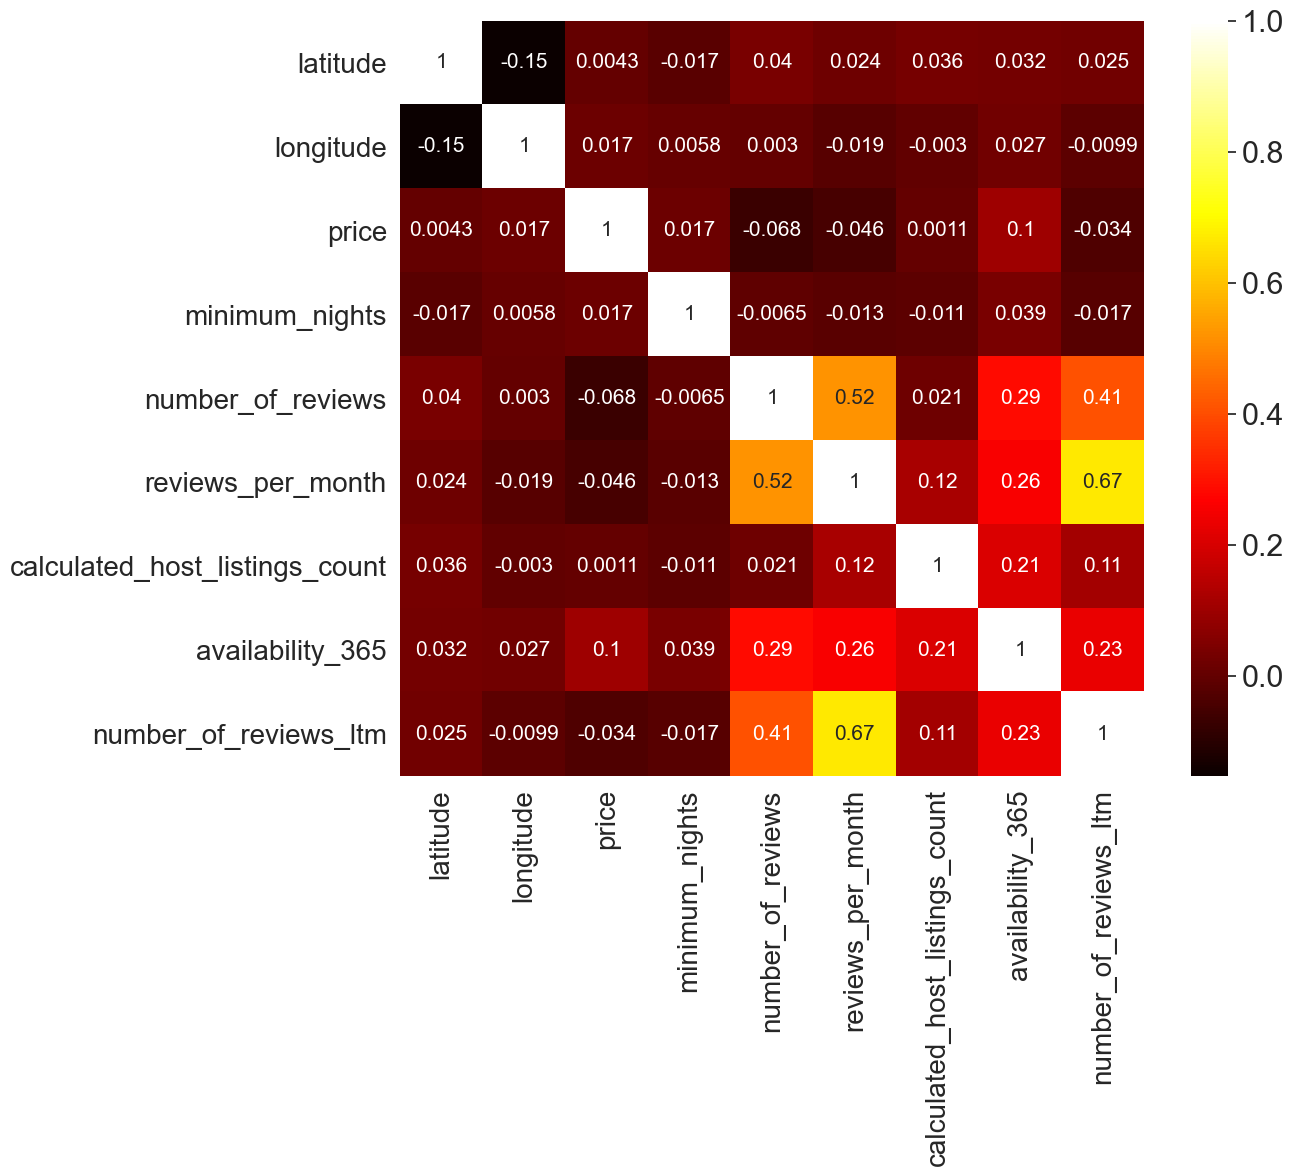

In [59]:
# raw data
disp_values = pd.get_dummies(values[disper_columns])
values_np = np.concatenate([conti_values, disp_values.to_numpy()], axis=1)

v = values.copy()
v_coor = v.corr()
plt.figure(figsize=(12, 10), dpi=100)
plt.xticks(size=20)
plt.yticks(size=20)
sns.heatmap(v_coor, annot=True, annot_kws={"size": 15}, cmap=plt.get_cmap('hot'))

归一化

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

scaler_y = StandardScaler()
poly = PolynomialFeatures(degree=2)

# define pipeline
pipe = Pipeline([
    ('poly', poly),
    ("std_scaler", std_scaler),
])

# transform data
y = scaler_y.fit_transform(y)
conti_values = pipe.fit_transform(conti_values)

# cat
data = np.concatenate([conti_values, disp_values, y], axis=1)

# split data
train_sets, val_sets = train_test_split(data, test_size=.2)

随机森林

In [61]:
rfr = RandomForestRegressor(n_estimators=20, random_state=22)
rfr.fit(train_sets[:, :-1], train_sets[:, -1])
rfr.score(val_sets[:, :-1], val_sets[:, -1])

0.7125796995682773

线性回归

In [62]:
from sklearn.linear_model import LinearRegression

lnreg = LinearRegression(normalize=True)
lnreg.fit(train_sets[:, :-1], train_sets[:, -1])
lnreg.score(val_sets[:, :-1], val_sets[:, -1])

1.0

SGD

In [63]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor()
sgd_reg.fit(train_sets[:, :-1], train_sets[:, -1])
sgd_reg.score(val_sets[:, :-1], val_sets[:, -1])

-2.9589036869734603e+21

MLP

In [64]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(150)
mlp.fit(train_sets[:, :-1], train_sets[:, -1])
mlp.score(val_sets[:, :-1], val_sets[:, -1])

0.9741819394186586

KNN

In [65]:
from sklearn.neighbors import KNeighborsRegressor

kreg = KNeighborsRegressor()
kreg.fit(train_sets[:, :-1], train_sets[:, -1])
kreg.score(val_sets[:, :-1], val_sets[:, -1])

0.6721614864306718

AdaBoost 

In [67]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(loss='square')
ada.fit(train_sets[:, :-1], train_sets[:, -1])
ada.score(val_sets[:, :-1], val_sets[:, -1])

0.9859824973389724